## INTRODUCTION 
# Kaggle competition to predict house prices
This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

It's a great dataset for evaluating simple regression models.

 

In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

# 1. DATA CLEANSING AND ANALYSIS

Let's first read in the house data as a dataframe "house" and inspect the first 5 rows

In [13]:
house = pd.read_csv("/home/polya/Downloads/data/kings_county/kc_house_data.csv")
house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Now its time for some general data inspection. Let's first examine to see if there are any nulls in the dataframe as well as look at the type of the data (i.e whether it is a string or numeric)

In [14]:
# Looking for nulls
print(house.isnull().any())
# Inspecting type
print(house.dtypes)

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_

The data is pretty clean. There are no pesky nulls which we need to treat and most of the features are in numeric format. Let's go ahead and drop the "id" and "date" columns as these 2 features will not be used in this analysis.

In [15]:
# Dropping the id and date columns
house = house.drop(['id', 'date'],axis=1)

**Pairplot Visualisation**

Let's create some Seaborn pairplots for the features ('sqft_lot','sqft_above','price','sqft_living','bedrooms') to get a feel for how the various features are distributed vis-a-vis the price as well as the number of bedrooms

In [16]:
#sns.pairplot(house[['sqft_lot','sqft_above','price','sqft_living','bedrooms']], hue='bedrooms', palette='afmhot',size=1.4)

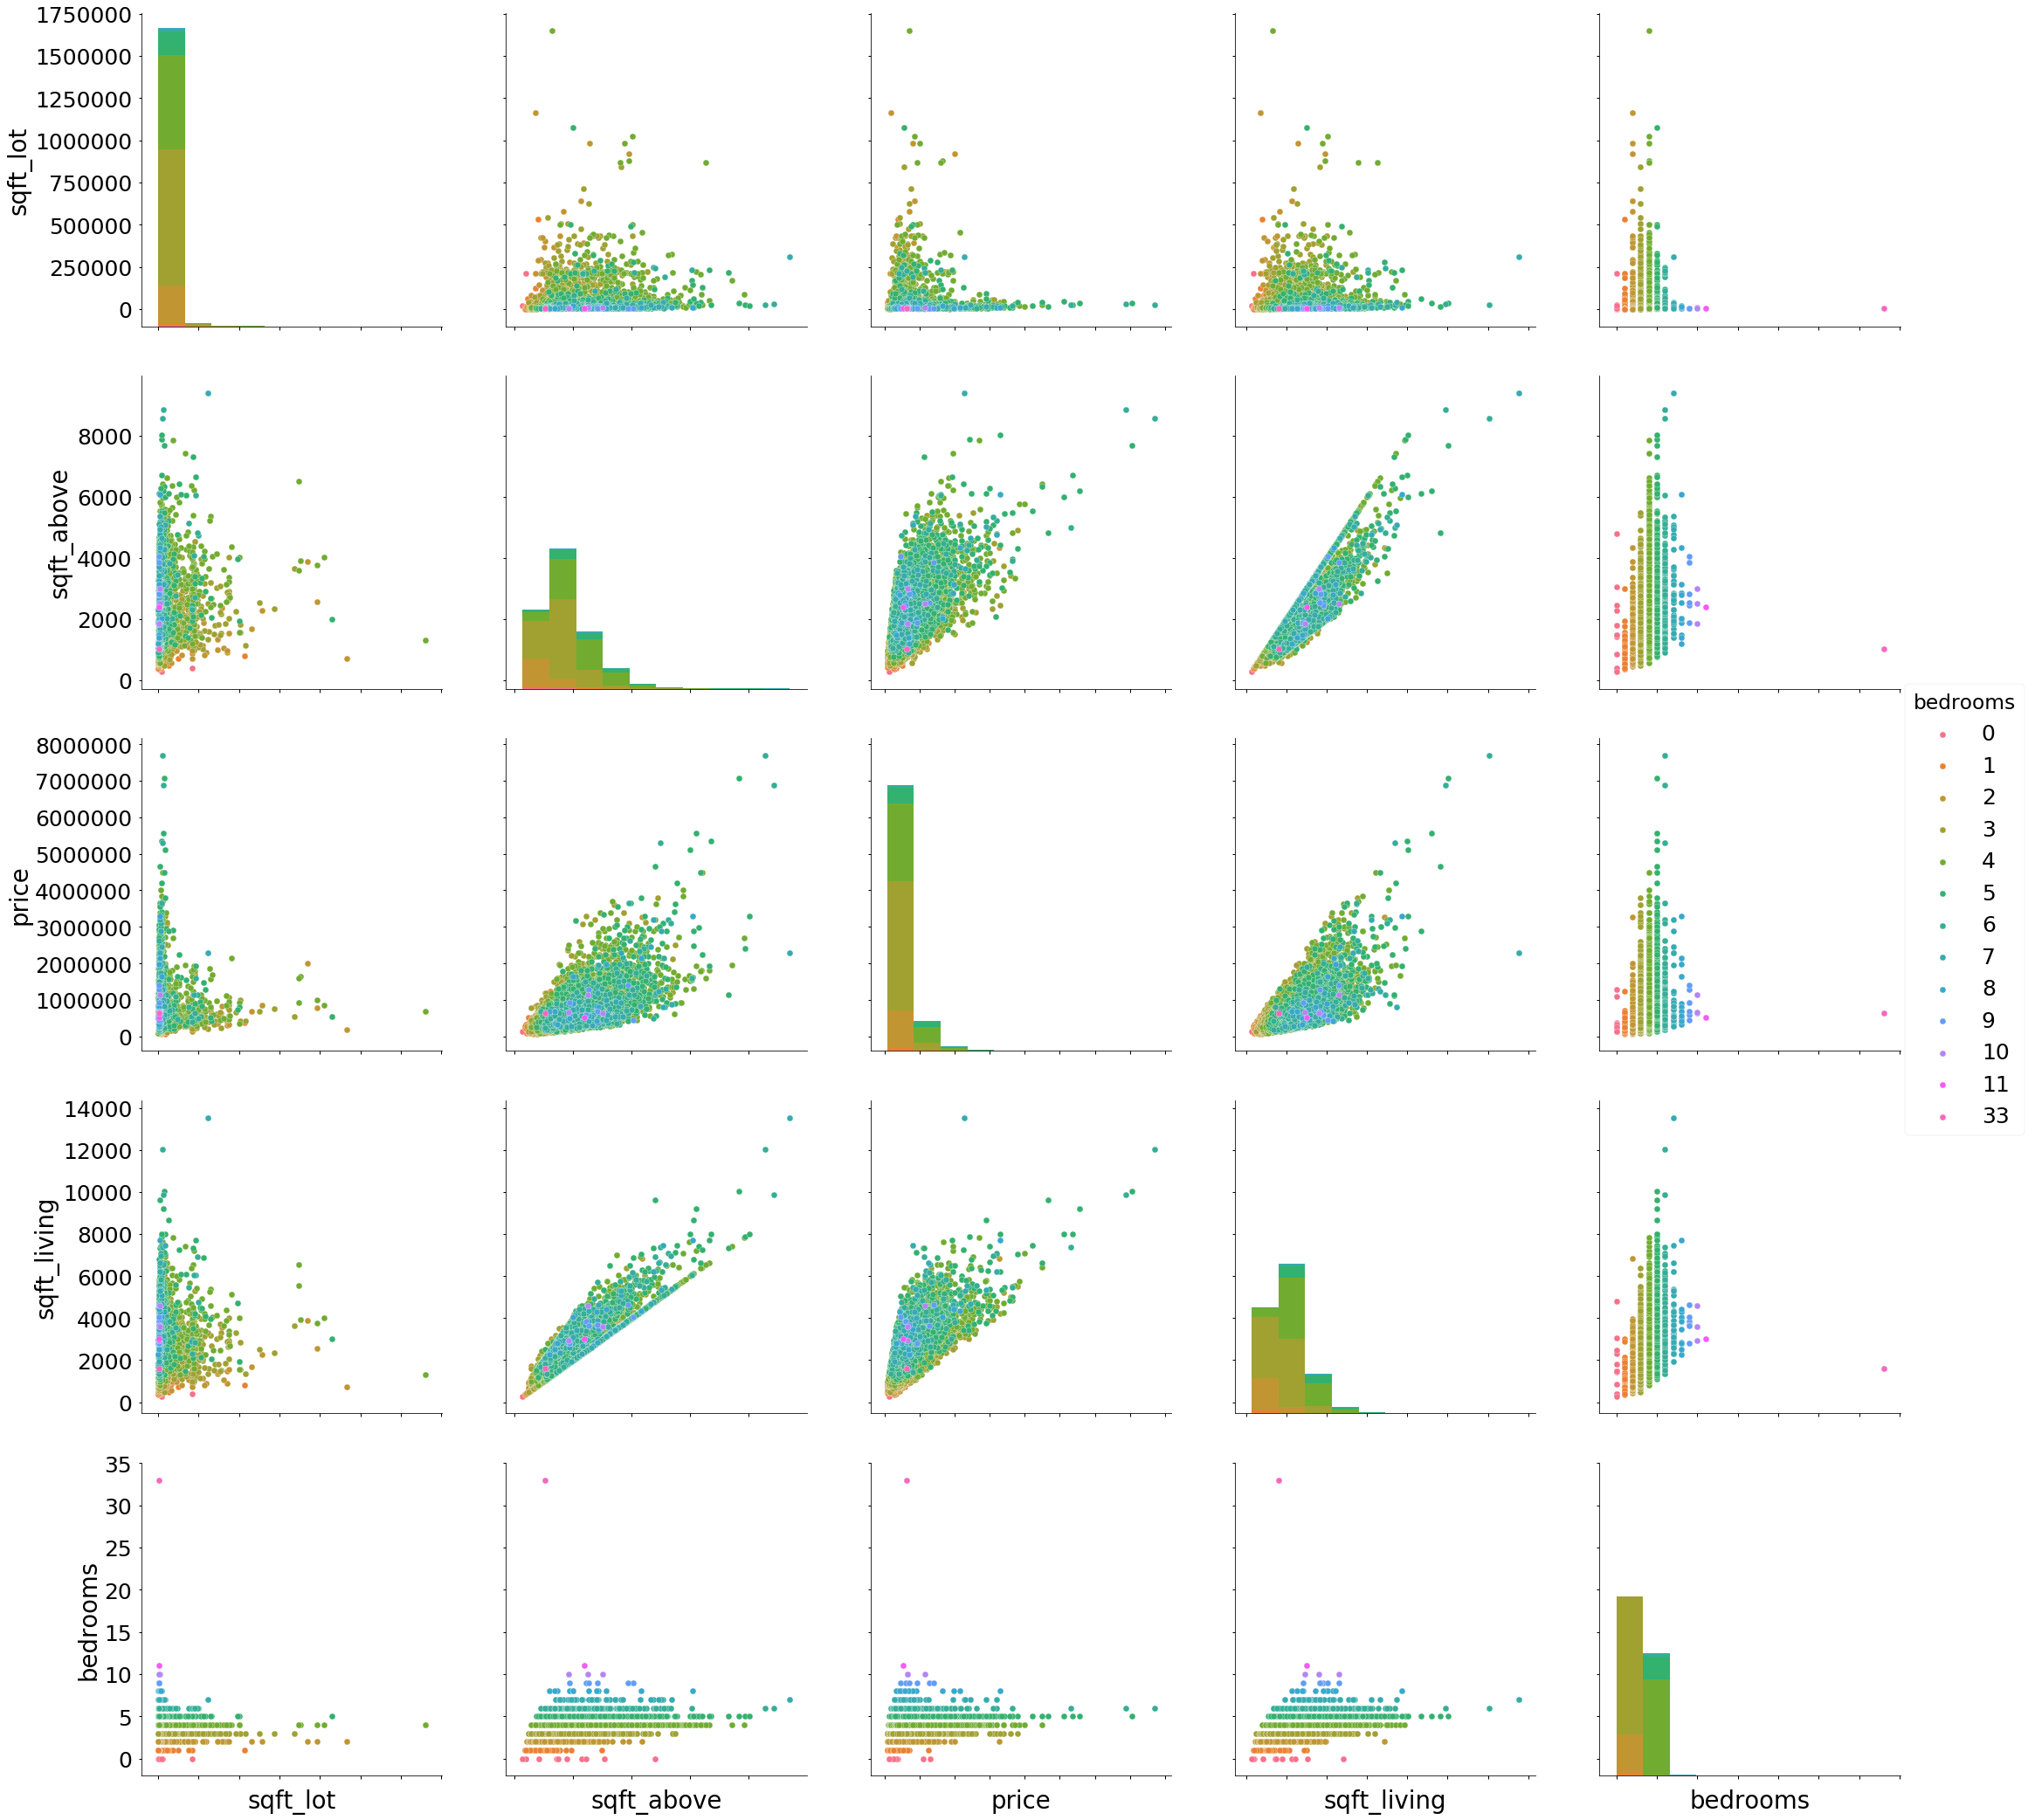

In [19]:
with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(house[['sqft_lot','sqft_above','price','sqft_living','bedrooms']], 
                 hue='bedrooms',size=6)
g.set(xticklabels=[]);

From the pairplots, we seem to get the classical linear distribution of the data points, for example with price against sqft_living. This bodes well as in the latter analysis, we will implement some linear models which we will use in our Feature ranking. Let's look at the correlation heatmap: 

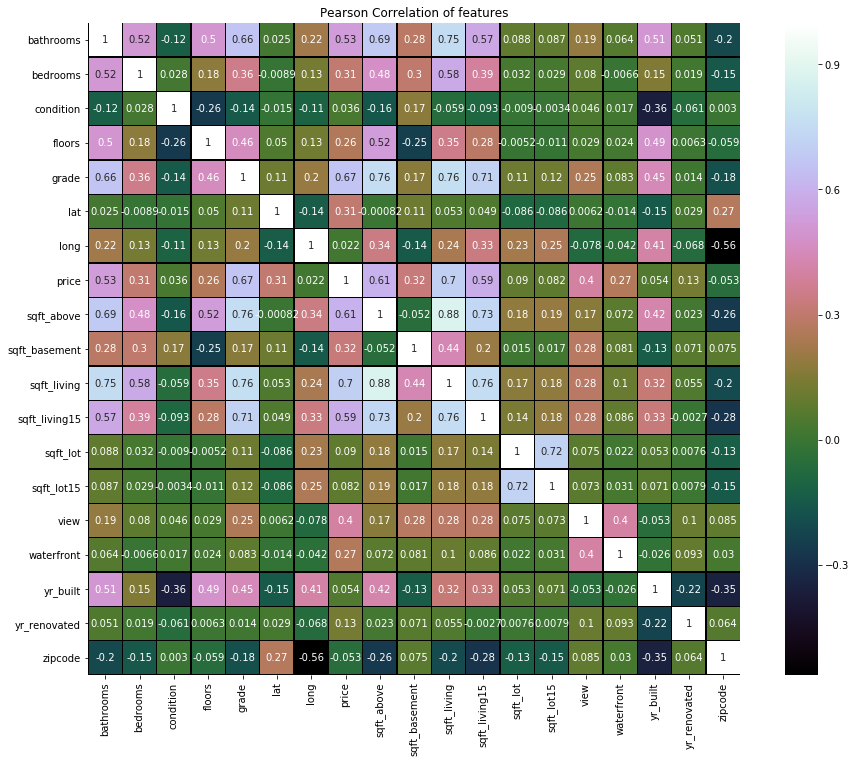

In [20]:
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in house.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = house.columns.difference(str_list) 
# Create Dataframe containing only numerical features
house_num = house[num_list]
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation of features')
# Draw the heatmap using seaborn
#sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="PuBuGn", linecolor='k', annot=True)
sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=True)

# 2. Stability Selection via Randomized Lasso

In a nutshell, this method serves to apply the feature selection on different parts of the data and features repeatedly until the results can be aggregated. Therefore stronger features ( defined as being selected as important) will have greater scores in this method as compared to weaker features. Refer to this paper by Nicolai Meinshausen and Peter Buhlmann for a much greater detail on the method : http://stat.ethz.ch/~nicolai/stability.pdf

In this notebook, the Stability Selection method is conveniently inbuilt into sklearn's randomized lasso model and therefore this will be implemented as follows:

In [21]:
# First extract the target variable which is our House prices
Y = house.price.values
# Drop price from the house dataframe and create a matrix out of the house data
house = house.drop(['price'], axis=1)
X = house.as_matrix()
# Store the column/feature names into a list "colnames"
colnames = house.columns

Next, we create a function which will be able to conveniently store our feature rankings obtained from the various methods described here into a Python dictionary. In case you are thinking I created this function, no this is not the case. All credit goes to Ando Saabas and I am only trying to apply what he has discussed in the context of this dataset.

In [22]:
# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [23]:
# Finally let's run our Selection Stability method with Randomized Lasso
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["rlasso/Stability"] = ranking(np.abs(rlasso.scores_), colnames)
print('finished')

finished


# 3. Recursive Feature Elimination ( RFE )

Now onto the next method in our feature ranking endeavour. Recursive Feature Elimination or RFE uses a model ( eg. linear Regression or SVM) to select either the best or worst-performing feature, and then excludes this feature. The whole process is then iterated until all features in the dataset are used up ( or up to a user-defined limit). Sklearn conveniently possesses a RFE function via the sklearn.feature_selection call and we will use this along with a simple linear regression model for our ranking search as follows:

In [24]:
# Construct our Linear Regression model
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(X,Y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


# 4. Linear Model Feature Ranking

Now let's apply 3 different linear models (Linear, Lasso and Ridge Regression) and how the features are selected and prioritised via these models. To achieve this, I shall use the sklearn implementation of these models and in particular the attribute .coef to return the estimated coefficients for each feature in the linear model.

In [25]:
# Using Linear Regression
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(X,Y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


# 5. Random Forest feature ranking

Sklearn's Random Forest model also comes with it's own inbuilt feature ranking attribute and one can conveniently just call it via "feature_importances_". That is what we will be using as follows:

In [ ]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(X,Y)
ranks["RF"] = ranking(rf.feature_importances_, colnames);

# 6. Creating the Feature Ranking Matrix

We combine the scores from the various methods above and output it in a matrix form for convenient viewing as such:

In [26]:
# Create empty dictionary to store the mean value calculated from all the scores
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

	Lasso	LinReg	RFE	Ridge	rlasso/Stability	Mean
bedrooms	0.06	0.0	0.47	0.06	1.0	0.32
bathrooms	0.07	0.0	0.41	0.07	1.0	0.31
sqft_living	0.0	1.0	0.88	0.0	0.51	0.48
sqft_lot	0.0	0.0	0.0	0.0	1.0	0.2
floors	0.01	0.0	0.29	0.01	1.0	0.26
waterfront	0.97	0.0	0.82	0.94	1.0	0.75
view	0.09	0.0	0.59	0.09	1.0	0.35
condition	0.04	0.0	0.53	0.04	1.0	0.32
grade	0.16	0.0	0.65	0.16	1.0	0.39
sqft_above	0.0	1.0	0.94	0.0	0.81	0.55
sqft_basement	0.0	1.0	1.0	0.0	0.0	0.4
yr_built	0.0	0.0	0.35	0.0	1.0	0.27
yr_renovated	0.0	0.0	0.12	0.0	1.0	0.22
zipcode	0.0	0.0	0.24	0.0	1.0	0.25
lat	1.0	0.0	0.76	1.0	1.0	0.75
long	0.36	0.0	0.71	0.35	1.0	0.48
sqft_living15	0.0	0.0	0.18	0.0	1.0	0.24
sqft_lot15	0.0	0.0	0.06	0.0	1.0	0.21


Now, with the matrix above, the numbers and layout does not seem very easy or pleasant to the eye. Therefore, let's just collate the mean ranking score attributed to each of the feature and plot that via Seaborn's factorplot.

In [27]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

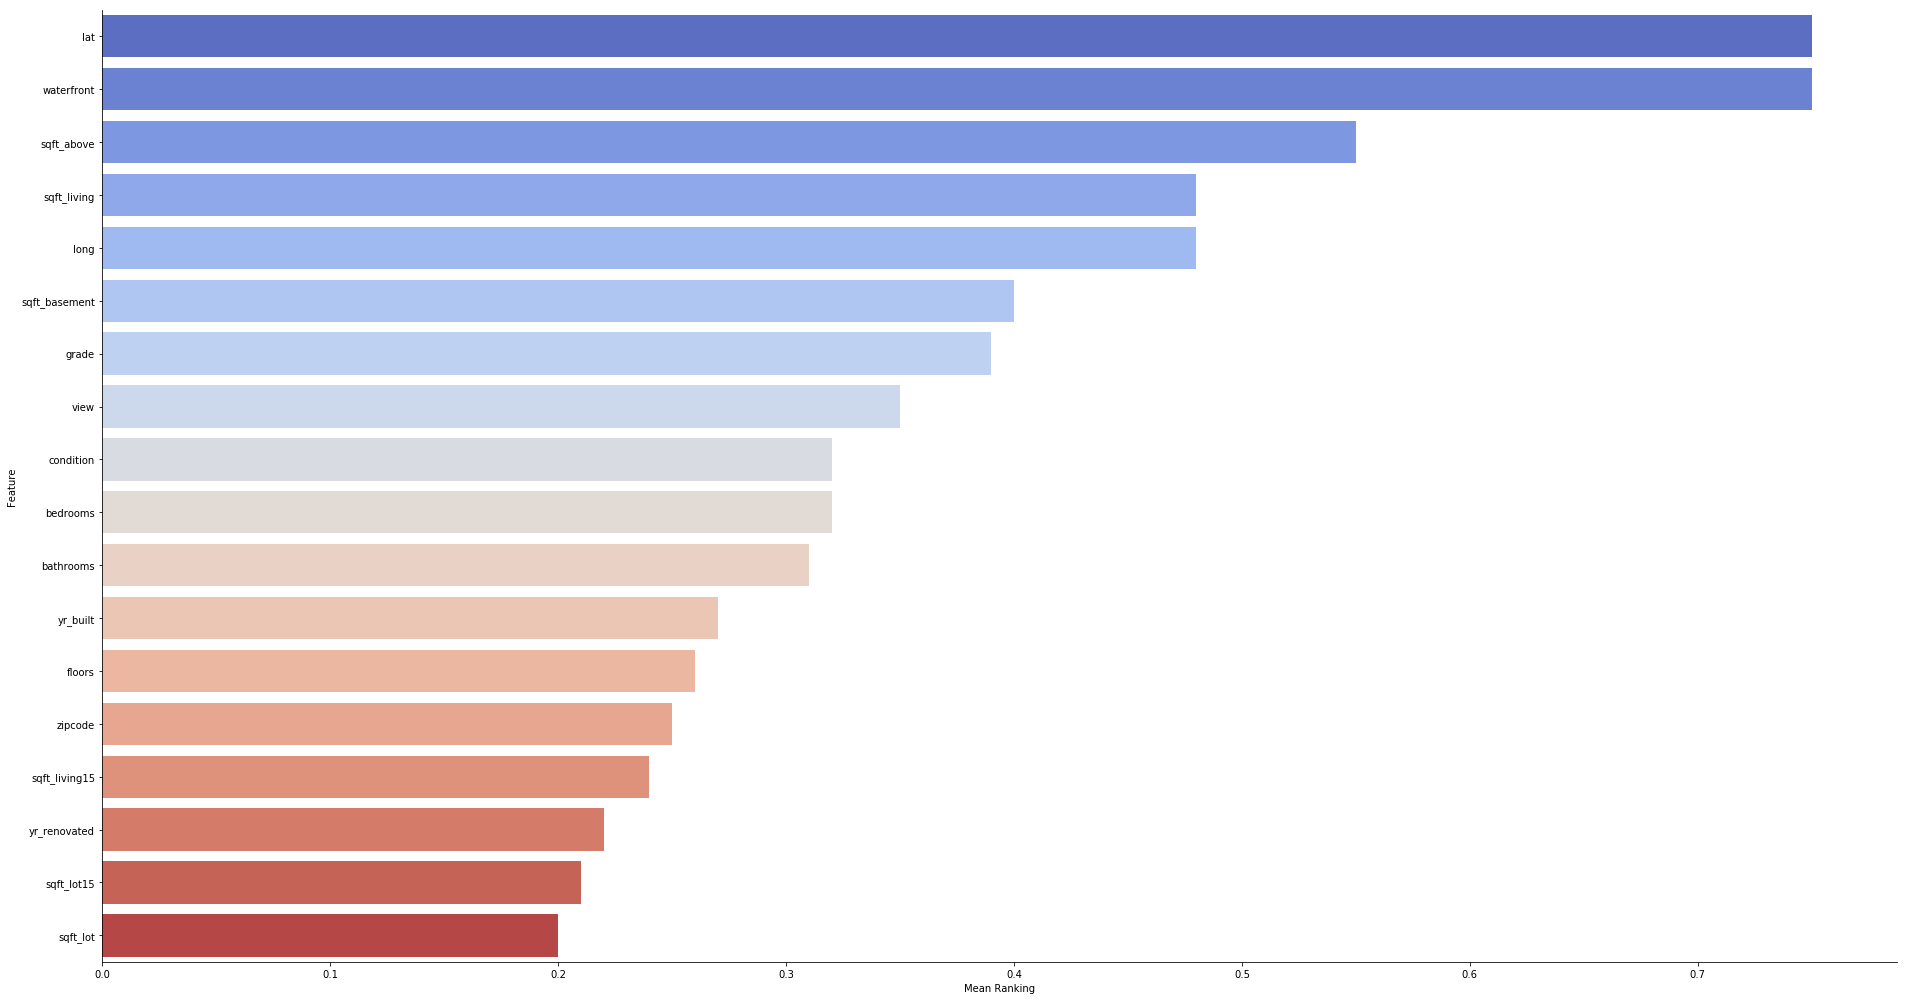

In [28]:
# Let's plot the ranking of the features
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=14, aspect=1.9, palette='coolwarm')

Well as you can see from our feature ranking endeavours, the top 3 features are 'lat', 'waterfront' and 'grade'. The bottom 3 are 'sqft_lot15', 'sqft_lot' and 'sqft_basement'. 
This sort of feature ranking can be really useful, especially if one has many many features in the dataset and would like to trim or cut off features that contribute negligibly.

In [1]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [46]:


from mleap import pyspark

from pyspark.ml.linalg import Vectors
from mleap.pyspark.spark_support import SimpleSparkSerializer
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import *


## Step: 1 Define custom schema

In [79]:
customSchema = StructType([ \
    StructField("id", StringType(), True), \
    StructField("date", StringType(), True), \
    StructField("price", DoubleType(), True), \
    StructField("bedrooms", DoubleType(), True), \
    StructField("bathrooms", DoubleType(), True), \
    StructField("sqft_living", DoubleType(), True), \
    StructField("sqft_lot", DoubleType(), True), \
    StructField("floors", DoubleType(), True), \
    StructField("waterfront", DoubleType(), True), \
    StructField("view", DoubleType(), True), \
    StructField("condition", DoubleType(), True), \
    StructField("grade", DoubleType(), True), \
    StructField("sqft_above", DoubleType(), True), \
    StructField("sqft_basement", DoubleType(), True), \
    StructField("yr_built", DoubleType(), True), \
    StructField("yr_renovated", DoubleType(), True), \
    StructField("zipcode", DoubleType(), True), \
    StructField("lat", DoubleType(), True), \
    StructField("long", DoubleType(), True), \
    StructField("sqft_living15", DoubleType(), True), \
    StructField("sqft_lot15", DoubleType(), True)])
 

## Step 2: Read the CSV file

In [80]:
housing_df = (
    spark.read.format("com.databricks.spark.csv").option("header","true").option("delimiter", ",").schema(customSchema)
    .load('file:////home/polya/Downloads/data/kings_county/kc_house_data.csv')
    .drop("id")
    .drop("date"))

In [81]:
housing_df

DataFrame[price: double, bedrooms: double, bathrooms: double, sqft_living: double, sqft_lot: double, floors: double, waterfront: double, view: double, condition: double, grade: double, sqft_above: double, sqft_basement: double, yr_built: double, yr_renovated: double, zipcode: double, lat: double, long: double, sqft_living15: double, sqft_lot15: double]

## Step 3: Define continous and categorical features

In [82]:
# Step 3. Create our features
continuous_features = ["bathrooms", "bedrooms", "sqft_living", "sqft_lot", "floors", "waterfront", "view", "condition","grade","sqft_above","sqft_basement","yr_built","yr_renovated","zipcode","lat","long","sqft_living15","sqft_lot15"]

categorical_features = []

all_features = continuous_features + categorical_features

In [83]:

dataset_imputed = housing_df.persist()



## Step 4: Train Test split

In [84]:
[training_dataset, validation_dataset] = dataset_imputed.randomSplit([0.7, 0.3])

## Step 5: Scaling features

In [85]:


continuous_feature_assembler= VectorAssembler(inputCols=continuous_features, outputCol="unscaled_continuous_features")

continuous_feature_scaler = StandardScaler(inputCol="unscaled_continuous_features", outputCol="scaled_continuous_features",\
                                           withStd=True, withMean=False)



## Step 6: One hot encode categoricals

In [86]:
categorical_feature_indexers = [StringIndexer(inputCol=x, outputCol="{}_index".format(x)) for x in categorical_features]

categorical_feature_one_hot_encoders = [OneHotEncoder(inputCol=x.getOutputCol(), outputCol="oh_encoder_{}".format(x.getOutputCol() )) for x in categorical_feature_indexers]

## Step 7: Create Pipeline

In [87]:


estimatorsLr = [continuous_feature_assembler, continuous_feature_scaler] + categorical_feature_indexers+ categorical_feature_one_hot_encoders

featurePipeline = Pipeline(stages=estimatorsLr)

sparkFeaturePipelineModel = featurePipeline.fit(dataset_imputed)

print("Finished constructing the pipeline")



Finished constructing the pipeline


## Step 8: Create model

In [88]:
# Create our linear regression model

linearRegression = LinearRegression(featuresCol="scaled_continuous_features", labelCol="price", predictionCol="price_prediction", maxIter=10, regParam=0.3, elasticNetParam=0.8)

pipeline_lr = [sparkFeaturePipelineModel] + [linearRegression]

sparkPipelineEstimatorLr = Pipeline(stages = pipeline_lr)

sparkPipelineLr = sparkPipelineEstimatorLr.fit(dataset_imputed)

print("Complete: Training Linear Regression")

Complete: Training Linear Regression


## Step 9: Serialize to Bundle ML

In [91]:
sparkPipelineLr.serializeToBundle("jar:file:/tmp/pyspark.lr.zip", sparkPipelineLr.transform(dataset_imputed))